# Intro

For trying new approach, I first considered the results of last approach. I saw there that mose misclassifications belong to two classes: T-shirt and shirt. So I decieded to try something to classify these two class more accurately.<br>
For this purpose, I use same structure from last approach, just add **loss weights** to train procedure. i.e. change the contribution to loss value for each class. 
The full structure of network can be seen below.<br>

<img src="https://github.com/amirfallah1988/Fashion-MNIST/blob/master/first_approach.png?raw=true" title= "network structre"/> <br>

**Why choosing this structure** <br>
To classify T-shirts and shirts more accurately, I believe that we have to concentrate more on results of these classes. For this purpose, I try to add weights to each class, based on their classification results in last approach.<br>
Here is the loss weight function which I used: <br>




## Class weights

In [7]:
indexes=pd.Index(['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'])
Weights=pd.DataFrame([1.5,.5,1.5,.5,1.5,.5,1.5,1,.5,1],index=indexes,columns=['Weights'])
Weights


,Weights
T-shirt/top,1.5
Trouser,0.5
Pullover,1.5
Dress,0.5
Coat,1.5
Sandal,0.5
Shirt,1.5
Sneaker,1.0
Bag,0.5
Ankle boot,1.0


## Importing modules

In [2]:
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import time

## Paramter setting

In [2]:
batch_size     = 64
nb_classes     = 10
nb_ephochs     = 100

## Load and prepare data
Here the fashion mnist dataset is loaded. The shape of dataset is proper (28x28), but for process with keras, need some modifications:<br>
**1-** The values of pixels are in range of 0-255. So it must normalize. For normalization I just divide each value by 255.<br>
**2-** The dimension of data must expand to 3.<br>
**3-** For use the data for classification task, I convert data's label to categorical form. <br>
**4-** Before divide -just for assurance- I shuffle the data.

In [4]:
# Load data
(All_data, All_labels), (x_test, y_test) = fashion_mnist.load_data()

# preprocess data

All_data=All_data/255
All_data=np.expand_dims(All_data, axis=3)
input_shape= (All_data.shape[1],All_data.shape[2],1)

All_labels_categorical=utils.to_categorical(All_labels, num_classes=nb_classes)

# shuffle data
p=np.random.permutation(len(All_data))
All_data=All_data[p]
All_labels_categorical=All_labels_categorical[p]


# prepare test data for further tests
x_test=x_test/255
x_test=np.expand_dims(x_test, axis=3)  
y_test_categorical=utils.to_categorical(y_test, num_classes=nb_classes)

## Data Augmentation
To improve the accuracy of model, I use augmentation techinques. The augmentation which I used comprises of these features:<br>

- Horizontal flip <br>
- Height shift <br>
- Width shift <br>

In [5]:
Datagen=ImageDataGenerator(horizontal_flip=True,
                                   fill_mode='constant',
                                    width_shift_range=0.1,
                                        height_shift_range=0.1)

## Network structure
In the next cell, the structure of model is defined.

In [6]:
x=layers.Input(shape=input_shape)


n_3x3=layers.Conv2D(32,kernel_size=3,padding='same',activation='relu')(x)
#n_3x3=layers.BatchNormalization()(n_3x3)
n_3x3=layers.SpatialDropout2D(.1)(n_3x3)
#n_3x3=layers.MaxPooling2D(2,padding='same')(n_3x3)
#n_3x3=layers.Conv2D(32,kernel_size=3,padding='same',activation='relu')(n_3x3)
#n_3x3=layers.BatchNormalization()(n_3x3)
#n_3x3=layers.MaxPooling2D(2,padding='same')(n_3x3)
#n_3x3=layers.Conv2D(8,kernel_size=3,padding='same',activation='relu')(n_3x3)
#n_3x3=layers.BatchNormalization()(n_3x3)

aux_input=layers.Conv2D(32,kernel_size=1,padding='same',activation='relu')(x)

#aux_input=layers.MaxPooling2D(2,padding='same')(aux_input)

output=layers.Add()([n_3x3,aux_input])
output=layers.BatchNormalization()(output)

output=layers.Conv2D(32,kernel_size=3,padding='valid',activation='relu')(output)
output=layers.MaxPooling2D(4,padding='same')(output)

#output=layers.BatchNormalization()(output)
output=layers.Flatten()(output)
output=layers.Dense(120,activation='relu')(output)
output=layers.Dropout(.4)(output)
output=layers.Dense(30,activation='relu')(output)
output=layers.Dense(10,activation='softmax')(output)

model=Model(x,output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout2d (SpatialDropo (None, 28, 28, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   64          input_1[0][0]                    
______________________________________________________________________________________________

## Optimizer, loss and metric
Based on my own experience and also after test SGD optimzers, I choosed ADAM optimzer with learning rate equal to 0.001.<br>
I also tested both MSE and categorical crossentropy as loss function and as I expected the categorical cross entropy was the better choice.<br>
For metric, I choose accuracy, just to find out number of correct prediction.

In [7]:
optimizer=optimizers.Adam(learning_rate=0.001)
loss=losses.CategoricalCrossentropy()
metric=metrics.Accuracy()

## Callbacks
I use two callbacks to handle the procedure of learning: <br>
**1-** Checkpoint model: to save the best model in learning procedure. <br>
**2-** Reduce on Plateau: to decay learning rate when there is no improvement in result.

In [8]:
mc=callbacks.ModelCheckpoint('second_approach_model.hdf5',save_best_only=True)
rop=callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=4 , min_delta=0.01,verbose=1)

## Train the model
**Note** <br>
**_- Cross validation techniques can be used in evaluating the performance of the model, but to hold the process succinct I didn't use it._** <br>
**- The data was splited to train and validation for evaluate the performance.**

In [11]:
# split data to train and validation
x_train,x_val,y_train_categorical,y_val_categorical=train_test_split(All_data,All_labels_categorical,test_size=.1)


# compile

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# train
start_time=time.time()
h=model.fit_generator(Datagen.flow(x_train, y_train_categorical, batch_size=batch_size),
            steps_per_epoch=round(len(x_train) / batch_size),
            epochs = nb_ephochs,
                validation_data=(x_val, y_val_categorical),
            # validation_split=.15 ,
                      class_weight={0:1.5,1:.5,2:1.5,3:.5,4:1.5,5:.5,6:1.5,7:1,8:.5,9:1},
            callbacks=[mc,rop],verbose=1
            )
train_time=time.time()-start_time



   

Epoch 1/100
844/844 [==============================] - 187s 221ms/step - loss: 0.7594 - accuracy: 0.7436 - val_loss: 0.4263 - val_accuracy: 0.8408
Epoch 2/100
844/844 [==============================] - 195s 231ms/step - loss: 0.6251 - accuracy: 0.7971 - val_loss: 0.3696 - val_accuracy: 0.8588
Epoch 3/100
844/844 [==============================] - 195s 231ms/step - loss: 0.5648 - accuracy: 0.8169 - val_loss: 0.3313 - val_accuracy: 0.8727
Epoch 4/100
844/844 [==============================] - 195s 231ms/step - loss: 0.5329 - accuracy: 0.8290 - val_loss: 0.3178 - val_accuracy: 0.8787
Epoch 5/100
844/844 [==============================] - 204s 242ms/step - loss: 0.5059 - accuracy: 0.8415 - val_loss: 0.3118 - val_accuracy: 0.8845
Epoch 6/100
844/844 [==============================] - 193s 229ms/step - loss: 0.4866 - accuracy: 0.8450 - val_loss: 0.3218 - val_accuracy: 0.8757
Epoch 7/100
844/844 [==============================] - 195s 231ms/step - loss: 0.4691 - accuracy: 0.8496 - val_loss: 0

Epoch 50/100
844/844 [==============================] - 194s 230ms/step - loss: 0.3131 - accuracy: 0.9025 - val_loss: 0.2151 - val_accuracy: 0.9185
Epoch 51/100
844/844 [==============================] - 198s 234ms/step - loss: 0.3146 - accuracy: 0.9032 - val_loss: 0.2296 - val_accuracy: 0.9137
Epoch 52/100
844/844 [==============================] - 187s 221ms/step - loss: 0.3110 - accuracy: 0.9038 - val_loss: 0.2175 - val_accuracy: 0.9195
Epoch 53/100
843/844 [============================>.] - ETA: 0s - loss: 0.3073 - accuracy: 0.9066
Epoch 00053: ReduceLROnPlateau reducing learning rate to 0.00047829695977270604.
844/844 [==============================] - 185s 220ms/step - loss: 0.3074 - accuracy: 0.9066 - val_loss: 0.2136 - val_accuracy: 0.9178
Epoch 54/100
844/844 [==============================] - 186s 220ms/step - loss: 0.3098 - accuracy: 0.9050 - val_loss: 0.2218 - val_accuracy: 0.9158
Epoch 55/100
844/844 [==============================] - 177s 210ms/step - loss: 0.3050 - accur

## Plotting results of train
The plots below shows the accuracy and loss changes in each epoch, respectively.

([<matplotlib.lines.Line2D at 0x17380506f88>],
 Text(0.5, 0, 'epoch'),
 Text(0, 0.5, 'loss'),
 Text(0.5, 1.0, 'Validation Plot'))

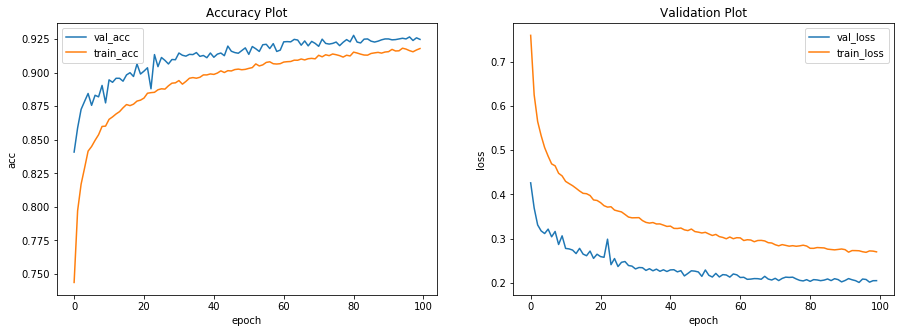

In [12]:
val_acc_logs=model.history.history['val_accuracy']
val_loss_logs=model.history.history['val_loss']


acc_logs=model.history.history['accuracy']
loss_logs=model.history.history['loss']

fig=plt.figure(figsize=(15,5))
fig.add_subplot(1, 2, 1)
plt.plot(val_acc_logs),plt.plot(acc_logs), plt.xlabel('epoch'), plt.ylabel('acc'),plt.legend(['val_acc','train_acc']),plt.title('Accuracy Plot')
fig.add_subplot(1, 2, 2)
plt.plot(val_loss_logs),plt.plot(loss_logs), plt.xlabel('epoch'), plt.ylabel('loss'),plt.legend(['val_loss','train_loss']),plt.title('Validation Plot')


## Time complexity of model
we print here the time of just one fit procedure (not whole kfold procedure). Note that the early stopping can change the time of procedure.

In [13]:
print ('The estimatd time for train the model:  {}  (seconds)'.format(train_time))

The estimatd time for train the model:  19631.264990329742  (seconds)


## Apply model on test data
Now its time to apply the model on test dataset to see whether the result is promising or not.

In [14]:
result=model.predict(x_test)
result=np.argmax(result,axis=1)
loss_test,acc_test=model.evaluate(x_test,y_test_categorical,verbose=0)
print ('test_accuracy, {:00.3f} % '.format(acc_test))
print ('test_loss, {:00.3f}'.format(loss_test))

test_accuracy, 0.919 % 
test_loss, 0.220


## Confusion Matrix
Here is the confusion matrix of test data to consider the results more precise.

In [15]:
conf_mat=confusion_matrix(y_test, result)
indexes=pd.Index(['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot'])
Table=pd.DataFrame(conf_mat,index=indexes,columns=indexes)
Table

,T-shirt/top,Trouser,Pullover,Dress,Coat,Sandal,Shirt,Sneaker,Bag,Ankle boot
T-shirt/top,863,2,12,7,1,1,109,0,5,0
Trouser,3,981,0,11,2,0,1,0,2,0
Pullover,14,1,885,6,34,0,60,0,0,0
Dress,10,6,7,870,53,0,53,0,1,0
Coat,2,0,41,10,888,0,57,0,2,0
Sandal,0,0,0,0,0,989,0,9,0,2
Shirt,101,0,34,8,57,1,795,0,4,0
Sneaker,0,0,0,0,0,12,0,980,0,8
Bag,2,0,0,1,1,2,5,0,989,0
Ankle boot,0,0,0,0,0,7,0,44,0,949


## Conclustion


In [16]:
stat_indexes=pd.Index(['Num_layers','Num_parameters','Total train_time','Accuracy'])
stat_table=pd.DataFrame([],index=stat_indexes)
stat_table.loc['Num_layers','value']=len(model.layers)
stat_table.loc['Num_parameters','value']=model.count_params()
stat_table.loc['Total train_time','value']=round(train_time,2)
stat_table.loc['Accuracy','value']=round(acc_test*100,2)
stat_table

,value
Num_layers,13.00
Num_parameters,201980.00
Total train_time,19631.26
Accuracy,91.89
